#Introducción:
En este cuaderno vamos a intentar analizar la existencia del llamado "ascensor social" en España a partir de los microdatos de la Encuesta de Condiciones de Vida (ECV) del año 2019. Dicho análisis nos sirve como excusa para tratar de mostrar en qué consiste una regresión logística y cómo llevarla a cabo en R.

En primer lugar, debemos definir qué es eso del "ascensor social" y cómo vamos a tratar de analizarlo nosostros. Éste se define como la posibilidad de ascender o descender de clase social. Aunque podemos considerar que la pertenencia a una determinada clase social - si es que éstas existen de forma estanca y perfectamente distinguible - se explica por una combinación de aspectos: nivel económico, cultural, de estudios, etc, nosotros nos vamos a centrar simplemente en el nivel económico.

Para ello, usaremos datos transversales de la ECV del año 2019. Este es el último año - hasta la fecha (2021) - que la ECV ha contado con el modulo temático *Transmisión intergeneracional de la pobreza* - batería de preguntas que nos permiten realizar el análisis deseado.

Los microdatos de la ECV 2019 pueden descargarse en el siguiente link: https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176807&menu=resultados&idp=1254735976608#!tabs-1254736195153. Dichos microdatos están formados por cuatro archivos:
* Fichero D: datos básicos del hogar (*esudb19d.csv*).
* Fichero R: datos básicos de la persona (*esudb19r.csv*).
* Fichero H: datos detallados del hogar (*esudb19h.csv*).
* Fichero P: datos detallados de los adultos (*esudb19p.csv*). En dicho fichero se encuentran las preguntas del módulo *Transmisión intergeneracional de la pobreza*.

Para poder unir los ficheros contamos con una variable de identificación por fichero. Las variables de identificación de los ficheros de hogares (DB030 y HB030) son idénticas; lo mismo para las variables de identificación de los ficheros de personas (RB030 y PB030). Éstas últimas se componen del identificador del hogar y el nº de orden, a dos dígitos, de la persona dentro del hogar.

Asimismo, al descargarse los microdatos, en la misma carpeta comprimida, encontramos un documento Word que contiene la explicación de todas las variables de la encuesta.

#¿Cómo determinamos si una persona ha mejorado o no su situación económica?
Para responder a esta pregunta vamos a utilizar las respuestas de los encuestados a dos cuestiones concretas:
1. **Situación económica del hogar cuando el adulto era	adolescente**. Las opciones de respuesta son:
  1. Muy mala
  2. Mala
  3. Moderadamente mala
  4. Moderadamente buena
  5. Buena
  6. Muy buena

Esta pregunta pertenece al módulo *Trasmisión intergeneracional de la pobreza* y, por tanto, se encuentra en el fichero P. Es la pregunta PT190.

2. **Capacidad del hogar para llegar a fin de mes.** Cuyas opciones de respuesta son:
  1. Con mucha dificultad.
  2. Con dificultad.
  3. Con cierta dificultad.
  4. Con cierta facilidad.
  5. Con facilidad.
  6. Con mucha facilidad.

Esta pregunta se refiere al hogar y se encuentra, específicamente, en el fichero H. Es la HS120.

Como vemos, las preguntas no son idénticas, ni siquiera sus opciones de respuesta lo son. Pero sí resultan muy similares y podemos utizarlas como proxy para determinar si una persona ha mejorado o no su situación económica.

Vamos a superponer, pues, lo siguiente: una persona ha mejorado su situación económica, es decir, ha logrado subir en el ascensor social, si ha mejorado en el número de su respuesta de la pregunta 1 a la 2. Por ejemplo: una persona que responde *Muy mala* (opción 1) en la pregunta 1, y *Con cierta dificultad* (opción 3) en la segunda pregunta, aunque su situación econónomica siga sin calificarla de "buena", **sí** que ha mejorado. Por el contrario si el número de la respuesta es el mismo o menor en la pregunta 2 que en la 1, dicha persona **no** habrá mejorado.

De esta manera, clasificaremos a los encuestados en dos categorías: 1) Personas que han mejorado - *han subido con el ascensor social*; 2) Personas que no han mejorado - *no han subido con el ascensor social*. Dicha sencilla categorización puede resultar simplista, pero nos permitirá llevar a cabo una regresión logística binaria, la más sencilla y, por ello, la más fácil de entender y realizar.

Esta variable binaria será la variable dependiente de nuestra regresión logística.

#Librerías:

In [ ]:
#Librería muy útil para el tratamiento de dataframes:
library(dplyr)
#Para llevar a cabo la regresión logística con pesos de muestreo (y que no dé error - la función más habitual glm() no maneja bien pesos de muestreo grandes):
install.packages("survey")
library(survey)

Para subir un archivo de datos (por ejemplo, un .csv) a Google Colab y trabajar con R debemos hacer lo siguiente:

1. Clicamos en el icono de la derecha de la pantalla que tiene forma de carpeta y se abre un desplegable a su derecha.
2. Clicamos en el icono que nos muestra una carpeta con una flecha hacia arriba en su interior.
3. Se abrirá una carpeta para que busquemos el archivo. Una vez seleccionado, le damos a "Abrir".
4. Esperamos a que se cargue y, una vez cargado, ya podemos usar la función de R apropiada para leer dicho archivo.

(Esta operación hay de carga hay que realizarla cada vez que se abra el cuaderno)

In [1]:
datos_Fichero_P <- read.csv("esudb19p.csv", sep=",")
head(datos_Fichero_P)

,PB010,PB020,PB030,PB040,PB040_F,PB100,PB100_F,PB110,PB110_F,PB120,⋯,PT180,PT180_F,PT190,PT190_F,PT260,PT260_F,PT270,PT270_F,PT280,PT280_F
,<int>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2019,ES,101,906.1583,1,12,1,2019,1,6,⋯,NA,-6,NA,-6,NA,-6,NA,-6,NA,-6
2,2019,ES,102,906.1583,1,12,1,2019,1,3,⋯,NA,-6,NA,-6,NA,-6,NA,-6,NA,-6
3,2019,ES,201,1227.6887,1,12,1,2019,1,5,⋯,NA,-6,NA,-6,NA,-6,NA,-6,NA,-6
4,2019,ES,202,1233.6804,1,12,1,2019,1,6,⋯,NA,-1,NA,-1,NA,-1,NA,-1,NA,-1
5,2019,ES,301,2559.3599,1,12,1,2019,1,8,⋯,5,1,4,1,1,1,1,1,3,1
6,2019,ES,302,2600.2733,1,12,1,2019,1,9,⋯,5,1,3,1,1,1,1,1,2,1


In [ ]:
cat("El número de filas del dataframe datos_Fichero_P es", nrow(datos_Fichero_P), "y el de columnas es", ncol(datos_Fichero_P))

El número de filas del dataframe datos_Fichero_P es 33376 y el de columnas es 244

In [3]:
datos_Fichero_H <- read.csv("esudb19h.csv", sep=",")
head(datos_Fichero_H)

,HB010,HB020,HB030,HB050,HB050_F,HB060,HB060_F,HB070,HB070_F,HB080,⋯,HD080,HD080_F,HI010T,HI010T_F,HI020T,HI020T_F,HI030T,HI030T_F,HI040T,HI040T_F
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2019,ES,1,12,1,2019,1,101,1,101,⋯,1,1,2,1,NA,-2,NA,-2,2,1
2,2019,ES,2,12,1,2019,1,201,1,201,⋯,1,1,2,1,NA,-2,NA,-2,2,1
3,2019,ES,3,12,1,2019,1,301,1,301,⋯,2,1,3,1,NA,-2,5,1,NA,-1
4,2019,ES,4,12,1,2019,1,401,1,401,⋯,2,1,3,1,NA,-2,9,1,3,1
5,2019,ES,6,11,1,2019,1,601,1,602,⋯,2,1,3,1,NA,-2,1,1,2,1
6,2019,ES,7,11,1,2019,1,701,1,701,⋯,1,1,2,1,NA,-2,NA,-2,2,1


In [ ]:
cat("El número de filas del dataframe datos_Fichero_H es", nrow(datos_Fichero_H), "y el de columnas es", ncol(datos_Fichero_H))

El número de filas del dataframe datos_Fichero_H es 15887 y el de columnas es 161

Vamos a crear una variable en el conjunto de datos *datos_Fichero_P* que sea igual a la variable identificadora del hogar HB030. Para ello, debemos quitar los dos últimos dígitos a la variable PB030. De esta forma, tendremos dos variables identificadoras idénticas que nos permitirán realizar la unión entre tablas.

In [4]:
#Para quitar los dos últimos dígitos dividimos entre 100, quedándonos solo con la parte entera:
datos_Fichero_P$HB030 = datos_Fichero_P$PB030 %/% 100

Llevamos a cabo, entonces, la unión de *dataframes*, usando las variables HB030 de cada *dataframe* como nexo de unión:

In [5]:
datos_conjuntos <- merge(x=datos_Fichero_P, y=datos_Fichero_H, by="HB030")
head(datos_conjuntos)

,HB030,PB010,PB020,PB030,PB040,PB040_F,PB100,PB100_F,PB110,PB110_F,⋯,HD080,HD080_F,HI010T,HI010T_F,HI020T,HI020T_F,HI030T,HI030T_F,HI040T,HI040T_F
,<dbl>,<int>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,2019,ES,101,906.1583,1,12,1,2019,1,⋯,1,1,2,1,NA,-2,NA,-2,2,1
2,1,2019,ES,102,906.1583,1,12,1,2019,1,⋯,1,1,2,1,NA,-2,NA,-2,2,1
3,2,2019,ES,201,1227.6887,1,12,1,2019,1,⋯,1,1,2,1,NA,-2,NA,-2,2,1
4,2,2019,ES,202,1233.6804,1,12,1,2019,1,⋯,1,1,2,1,NA,-2,NA,-2,2,1
5,3,2019,ES,301,2559.3599,1,12,1,2019,1,⋯,2,1,3,1,NA,-2,5,1,NA,-1
6,3,2019,ES,302,2600.2733,1,12,1,2019,1,⋯,2,1,3,1,NA,-2,5,1,NA,-1


In [ ]:
cat("El número de filas del dataframe datos_conjuntos es", nrow(datos_conjuntos), "y el de columnas es", ncol(datos_conjuntos))

El número de filas del dataframe datos_conjuntos es 33376 y el de columnas es 405

Como vemos, tenemos un nuevo *dataframe* cuyo número de filas es igual al número de filas del fichero P (el más grande, ya que hay más personas que hogares), y cuyo número de columnas es igual a la suma de las variables de los ficheros P y H.

A continuación, creamos la variable MSE (*Mejora_Situación_Económica*). Dicha variable tendrá valor 1 si la situación económica de cada persona ha mejorado con los años y valor 0, si no lo ha hecho:

In [6]:
datos_conjuntos$MSE <- ifelse(datos_conjuntos$PT190 < datos_conjuntos$HS120, 1, 0)
cat("El número de personas que han mejorado su situación económica es de", nrow(filter(datos_conjuntos, MSE == 1)), ". Mientras que el resto,", nrow(filter(datos_conjuntos, MSE == 0)), ", no han mejorado su situación económica. \n")
cat("El número de valores missing de la variables MSE es", sum(is.na(datos_conjuntos$MSE)), "La grandísima mayoría -", sum(is.na(datos_conjuntos$PT190)), "- se deben a los valores missing que presentaba la variable PT190.")

El número de personas que han mejorado su situación económica es de 3168 . Mientras que el resto, 14299 , no han mejorado su situación económica. 
El número de valores missing de la variables MSE es 15909 La grandísima mayoría - 15900 - se deben a los valores missing que presentaba la variable PT190.

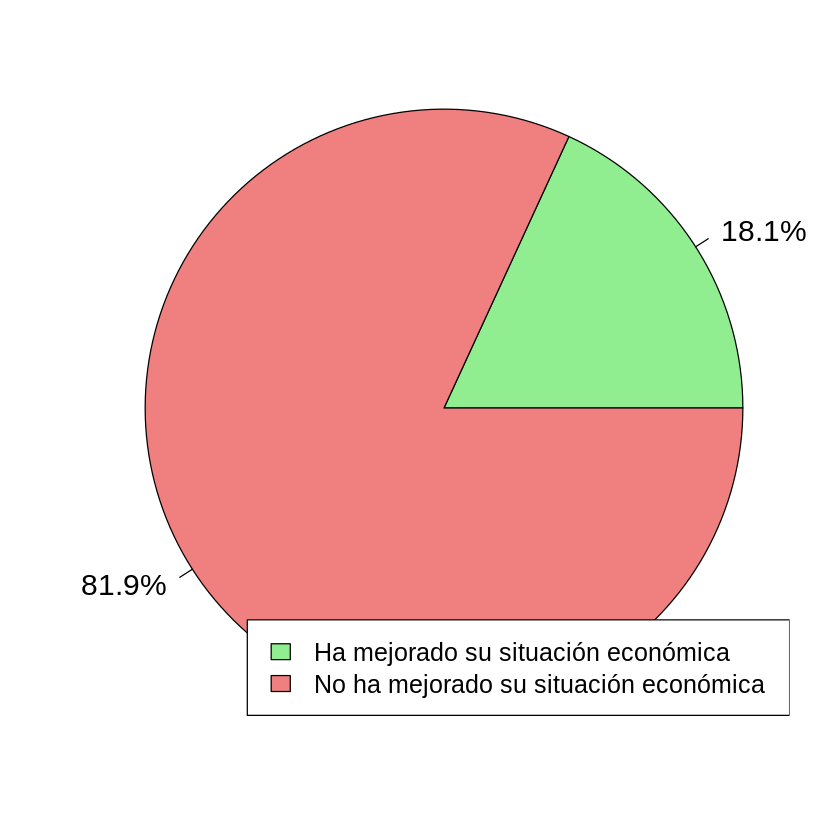

In [9]:
#Creamos un gráfico de quesito o de sectores para ver qué proporción de personas ha mejorado su situación económica:
datos_quesito <- c(nrow(filter(datos_conjuntos, MSE == 1)), nrow(filter(datos_conjuntos, MSE == 0)))
etiquetas <- c("Ha mejorado su situación económica", "No ha mejorado su situación económica")
porcentajes <- paste0(round(datos_quesito/sum(datos_quesito)*100, 1), "%")
colores <- c("lightgreen", "lightcoral")
pie(datos_quesito, labels = porcentajes, col = colores, radius=1.05, cex=1.5)
legend("bottomright", etiquetas, cex=1.25, fill = colores)

#¿En qué consiste la regresión logística?
Un análisis de regresión logística es una técnica estadística multivariante que tiene como finalidad pronosticar o explicar los valores de una variable dependiente categórica a partir de una (regresión logística simple) o más (regresión logística múltiple) variables independientes categóricas o continuas. Dichas variables independientes reciben el nombre de *covariables*. Asimismo, a diferencia de lo que suele hacerse cuando tenemos una variable dependiente continua, cuando ésta es categórica, no interesa describir o pronosticar los valores concretos de dicha variable, sino la probabilidad de pertenecer a cada una de las categorías de la misma.

Para entender mejor en qué consiste una regresión logística debemos partir de la ecuación de un modelo de regresión lineal clásico:
\begin{align}
Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n + ϵ
\end{align}

Para emplear estos modelos de regresión lineal clásicos con datos muestrales (lo normal, vamos) se deben cumplir una serie de supuestos: (1) linealidad, (2) no colinealidad, (3) independencia, (4) normalidad y (5) homocedasticidad.

Sin embargo, aunque matemáticamente se pueda ajustar un modelo de regresión lineal clásico a la relación entre una variable dependiente categórica y una o varias covariables, cuando la variable dependiente es dicotómica (regresión logística binaria, caso más sencillo de regresión logística) no es apropiado utilizar un modelo de regresión lineal porque una variable dicotómica no se ajusta a una distribución normal, sino a una binomial. Ignorar esta cuestión podría llevar a obtener probabilidades imposibles: menores que cero o mayores que uno.

Para evitar este problema, es preferible utilizar funciones que realicen predicciones comprendidas entre un máximo y un mínimo. Una de estas funciones - posiblemente la más empleada - es la *curva logística* o *función sigmoide*:

\begin{align}
\sigma(Y) = \frac{1}{1+e^{-(Y)}} =  \frac{1}{1+e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n + ϵ)}} = P(Y=1)
\end{align}

De esta forma, para valores positivos muy grandes de Y, $e^{-Y}$ es aproximadamente cero, por lo que el valor de la función es 1; mientras que para valores negativos muy grandes de Y, $e^{-Y}$ tiende a infinito, haciendo que el valor de la función sea 0.

A continuación, para simplificar un poco las cosas, consideremos el modelo de regresión logística más sencillo: regresión logística binaria simple (una sola covariable):
\begin{align}
P(Y=1)=\frac{1}{1+e^{-(\beta_0 + \beta_1X_1 + ϵ)}}
\end{align}

La interpretación de esta función es muy similar a la de una regresión lineal: el coeficiente $\beta_0$ representa la posición de la curva sobre el eje horizontal o de abscisas (más hacia la izquierda o más hacia la derecha); mientras que $\beta_1$ representa la pendiente de la curva, es decir, cuán inclinada está en su parte central (cuanto más inclinada, mayor capacidad de discriminar entre los dos valores de la variable dependiente).
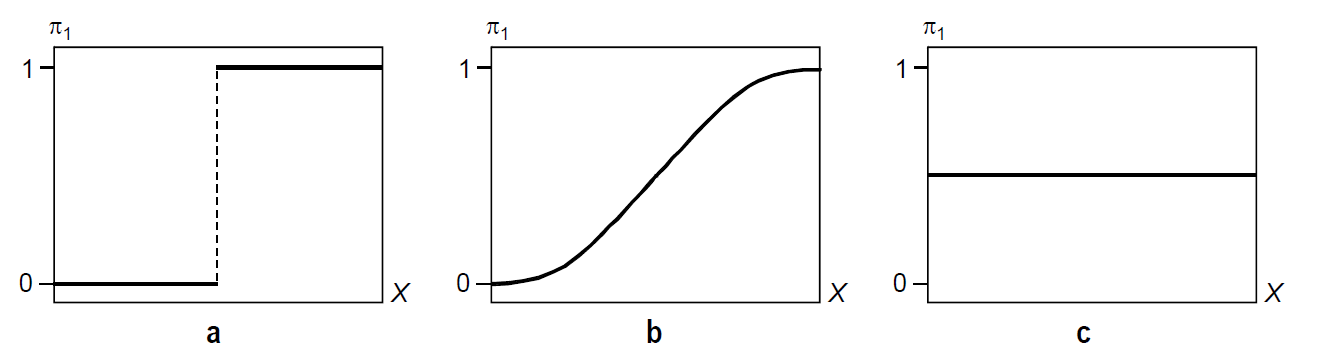

Esta imagen, sacada del libro *Análisis de datos en Ciencias Sociales y de la Salud III* (Pardo et al., 2012) muestra tres regresiones logísticas con el mismo coeficiente $\beta_0$, pero distinto poder discriminante (diferente $\beta_1$): la curva de la izquierda tendría un poder de discriminación perfecto, mientras que la de la derecha no discrimina nada (la del medio sería un caso intermedio entre los dos extremos). Por lo tanto, podemos decir que una covariable será mejor predictora cuanto mayor sea el coeficiente $\beta$ que genere.  [Aclaración: en la imagen, $\pi_1 = P(Y=1)$]

Si estuviésemos ante una regresión logística múltiple, cada variable independiente recibiría una ponderación proporcional a su capacidad para predecir Y.

##¿Pero cómo interpretamos los coeficientes de la regresión logística?
En general, en un modelo de regresión lineal, el valor del coeficiente $\beta_n$ representa cuánto varía la variable dependiente cuando varía en una unidad la variable $X_n$ (independiente). En un modelo de regresión logística, la interpretación no es tan sencilla. Para entenderla, utilizaremos un sencillo ejemplo práctico: vamos a realizar una regresión binaria simple, empleando las siguientes variables:
* Variable dependiente: MSE. Dos categorías: **Ha mejorado su situación económica** = 1; **No ha mejorado su situación económica** = 0.
* Variable independiente o covariable: Estado_civil (obtenida a partir de la variable PB190). La variable PB190 - pregunta sobre el estado civil del encuestado - está codificada de la siguiente manera: *Soltero* = 1; *Casado* = 2; *Separado* = 3; *Viudo* = 4; *Divorciado* = 5. A partir de esta variable, crearemos otra, llamada *Estado_civil* que estará codificada de la siguiente manera: **No casado** = 0; **Casado** = 1.
* Factor de elevación: variable PB040. El factor de elevación muestra el número de unidades de la población - el número de personas, en este caso -, que están representadas por cada unidad, cada persona, de la muestra. Es una variable que nos permite obtener resultados poblacionales.

In [11]:
#Creamos un pequeño dataset con las variables que vamos a utilizar:
datos1 = datos_conjuntos[,c("MSE","PB040", "PB190")]
#Cambiamos el nombre de las variables para que quede más claro lo que vamos a hacer:
datos1 = rename(datos1, Factor_de_elevacion = PB040, Estado_civil = PB190)
#Recodificamos la variable Estado_civil: todas las categorias diferentes a 2, recibiran el valor 0; y la categoria 2 (Casado), el valor 1
datos1$Estado_civil <- ifelse(datos1$Estado_civil != 2, 0, 1)
head(datos1, 5)

,MSE,Factor_de_elevacion,Estado_civil
,<dbl>,<dbl>,<dbl>
1,NA,906.1583,1
2,NA,906.1583,1
3,NA,1227.6887,1
4,NA,1233.6804,1
5,0,2559.3599,0


In [14]:
#Creamos el modelo de regresión logística:
modelo <- svyglm(MSE ~ Estado_civil, design=svydesign(ids=~1, weights=~Factor_de_elevacion, data=datos1), family=binomial)
#Mostramos el resultado:
summary(modelo)
#(Nos arroja un warning que significa que el número de éxitos no es integrable, pero no pasa nada, R ajusta el modelo de todas formas sin problemas)
#Si queremos evitar que nos salga el warning podemos usar family = quasibinomial en lugar de family = binomial

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = MSE ~ Estado_civil, design = svydesign(ids = ~1, 
    weights = ~Factor_de_elevacion, data = datos1), family = binomial)

Survey design:
svydesign(ids = ~1, weights = ~Factor_de_elevacion, data = datos1)

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.73590    0.05124  -33.88  < 2e-16 ***
Estado_civil  0.38154    0.06317    6.04 1.57e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.085272)

Number of Fisher Scoring iterations: 4


Fijémonos en los coeficientes del intercepto ($\beta_0$) y de la variable *Estado_civil* ($\beta_1$). La ecuación de regresión logística sería:
\begin{align}
P(Y=1)=\frac{1}{1+e^{-(\beta_0 + \beta_1X_1)}}=\frac{1}{1+e^{-(-1,7359 + 0,3815X_1)}}
\end{align}

Entonces, como la variable *Estado_civil* tiene dos categorías: **No casado** ($X=0$) y **Casado** ($X=1$), la probabilidad pronosticada por la ecuación de regresión logística para la categoría **No casado** es:
\begin{align}
P(Y=1|X=0)=\frac{1}{1+e^{-(-1,7359 + 0,3815*0)}}=\frac{1}{1+e^{1,7359}}= 0,1498
\end{align}

In [16]:
PY1X0 <- 1/(1+exp(1.7359))
round(PY1X0, 4)

[1] 0.1498

Mientras que la probabibilidad pronosticada en el caso de que la persona encuestada sea mujer vale:
\begin{align}
P(Y=1|X=1)=\frac{1}{1+e^{-(-1,7359 + 0,3815*1)}}=\frac{1}{1+e^{1,3544}}= 0,2052
\end{align}

Por tanto, podemos decir que la probabilidad de que una persona haya mejorado su sitación económica con respecto a su adolescencia es mayor - un 37% - si es está casada, que si no lo está.

In [17]:
PY1X1 <- 1/(1+exp(1.3544))
round(PY1X1, 4)

[1] 0.2052

Continuémos con la interpretación de los coeficientes. Como la variable dependiente es dicotómica y se asume que sus dos categorías no se solapan y agotan el espacio muestral, es decir, son sucesos contrarios, entonces $P(Y=1) = 1-P(Y=0)$.

Realicemos entonces, el cociente entre probabilidades:
\begin{align}
\frac{P(Y=1)}{P(Y=0)}=\frac{\frac{1}{1+e^{-(\beta_0 + \beta_1X_1)}}}{1-\frac{1}{1+e^{-(\beta_0 + \beta_1X_1)}}}=e^{\beta_0 + \beta_1X_1}
\end{align}

Este cociente es conocido como *odds* (traducido en algunos caso como *ventaja*) del suceso $Y=1$ (en nuestro caso, la persona ha mejorado su situación económica) frente al suceso $Y=0$ (la persona no ha mejorado su situación económica). Así pues, la *odds* de un suceso es el cociente entre la probabilidad de que el suceso ocurra y la probabilidad de que no ocurra. En el ejemplo, la *odds* del suceso **Ha mejorado su situación económica** cuando la persona es hombre vale:
\begin{align}
e^{\beta_0 + \beta_1*0}=e^{-1,7359}=0,1762
\end{align}

In [18]:
oddsY1X0 <- exp(-1.7359)
round(oddsY1X0, 4)

[1] 0.1762

Mientras que la *odds* de ese mismo suceso, cuando la persona es mujer vale:
\begin{align}
e^{\beta_0 + \beta_1*1}=e^{-1,7359 + 0,3815}=e^{-1,3544}=0,2581
\end{align}


In [20]:
oddsY1X1 <- exp(-1.3544)
round(oddsY1X1, 4)

[1] 0.2581

Para bajar los coeficientes del exponente, debemos aplicar logaritmos a la expresión anterior:
\begin{align}
\ln(\frac{P(Y=1)}{P(Y=0)})=\ln(e^{\beta_0 + \beta_1X_1})=\beta_0 + \beta_1X_1
\end{align}

Al realizar esta transformación, llamada *log-odds*, transformación *logit* o simplemente *logit*, la parte derecha de la ecuación toma la forma de un modelo de regresión lineal. Por tanto, al hacer la transformación *logit*, conseguimos convertir un problema de clasificación no lineal, en un problema de regresión lineal, lo que nos permitirá interpretar el coeficiente de regresión de un modelo logístico como el cambio que se produce en la transformación *logit* cuando varía en una unidad la variable independiente.

Siguiendo con los datos del ejemplo anterior, la transformación *logit* del suceso **Ha mejorado su situación económica** (Y=1), cuando la persona no está casada (X=0), vale:
\begin{align}
\ln(\frac{P(Y=1|X=0)}{P(Y=0|X=0)})=\beta_0 =\ln(\frac{0,1498}{1-0,1498})= -1,7359
\end{align}




In [21]:
LogitY1X0 <- log(PY1X0/(1-PY1X0))
round(LogitY1X0, 4)

[1] -1.7359

Y la transformación *logit* del suceso **Ha mejorado su situación económica** (Y=1), cuando la persona está casada (X=1), es:
\begin{align}
\ln(\frac{P(Y=1|X=1)}{P(Y=0|X=1)})=\beta_0 + \beta_1X_1=\ln(\frac{0,2052}{1-0,2052})= -1,3544
\end{align}

In [23]:
LogitY1X1 <- log(PY1X1/(1-PY1X1))
round(LogitY1X1, 4)

[1] -1.3544

Asimismo, como:
\begin{align}
\ln(\frac{P(Y=1|X=0)}{P(Y=0|X=0)})=\beta_0 = -1,7359
\end{align}

Podemos comprobar que $\beta_1$ es igual a la diferencias entre logaritmos:
\begin{align}
\beta_1 = -1,3544 - (-1,7359) = 0,3815
\end{align}

In [24]:
round(LogitY1X1 - LogitY1X0, 4)

[1] 0.3815

Y dicho coeficiente $\beta_1$ se interpreta de la siguiente forma:  el logaritmo de la *odds*, de la *ventaja*, del suceso $Y=1$ frente al suceso $Y=0$ es $0,3815$ veces mayor entre las personas casadas ($Estado\_civil = 1$) que entre las no casadas ($Estado\_civil = 0$).

Igualmente, debemos advertir que tanto $P(Y=1)$, como $odds(Y=1)$, como $logit(Y=1)$ expresan la misma idea, aunque en distinta escala:
* La probabilidad toma valores comprendidos entre 0 y 1.
* La *odds* tiene un valor mínimo de cero y no tiene máximo.
* La *logit* no tiene ni mínimo ni máximo.

Por ejemplo, a una probabilidad de 0,5, le corresponde una *odds* de 1 y un *logit* de 0.

Ahora bien, es cierto que razonar en términos de cambios en los logaritmos resulta poco intuitivo. Por ello, es preferible interpretar el cambio en las *odds* - que ya vimos cómo se calculaban - o en la *razón de ventajas* (también llamada *odds ratio*, *razón de probabilidades* o *razón de momios*).

Volviendo a nuestro ejemplo, la *odds-ratio* tiene el siguiente valor:
\begin{align}
\frac{e^{-1,7359+0,3815}}{e^{-1,7359}}=\frac{e^{-1,3544}}{e^{-1,7359}}=\frac{0,2581}{0,1762}=1,4645
\end{align}

In [25]:
odds_ratio <- exp(-1.3544)/exp(-1.7359)
round(odds_ratio, 4)

[1] 1.4645

Pasar de 0 a 1 en la covariable *Estado_civil* hace que la *odds ratio* del suceso **Ha mejorado su situación económica** frente al suceso **No ha mejorado su situación económica** valga $1,4645$. Esto significa que la *odds*, la *ventaja* del suceso **Ha mejorado su situación económica** es $1,4645$ veces mayor entre las personas casadas que entre las no casadas

Utilizar la *odds-ratio* nos permite interpretar los coeficientes teniendo en cuenta lo siguiente:
* Si $odds\ ratio=1$: la variable independiente no produce ningún efecto sobre la *ventaja/odds* del suceso (el coeficiente de regresión de la variable independiente valdría cero).
* Si $odds\ ratio>1$: un aumento de la variable independiente conlleva un aumento de la ventaja del suceso (el coeficiente de regresión de la variable independiente sería mayor que 0).
* Si $odds\ ratio<1$: un aumento de la variable independiente supone una disminución de la ventaja del suceso (el coeficiente de regresión de la variable independiente sería menor que 0).

Por último, dentro de este apartado, debemos mencionar que en contextos relacionados con la salud, cuando la variable dependiente hace referencia a la aparición de una enfermedad o similar, a las covariables cuya *odds ratio* es mayor que 1 se les llama **factores de riesgo**, y a las covariables con *odds ratio* menor que 1, **factores de protección**.